This notebook is to visualize the sampled predictive destribution of classes from MNIST dataset and a look at how the authors estimate uncertainties in predictions.

As usual, we clone the repository to get the PyTorch models


In [1]:
#!git clone https://github.com/pankajb64/bayescnn.git

The models are stored under `bayescnn/Bayesian_CNN/utils/`. Change the working directory so python can find the `utils`  modules.

In [2]:
#import os
#os.chdir('bayescnn/Bayesian_CNN')

Now we do all the relevant imports

In [1]:
#@title
from __future__ import print_function

import os
import sys
import time
import argparse
import datetime
import math
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import torchvision
import torchvision.transforms as transforms

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

#import Bayesian_config as cf
from scipy.special import softmax
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

In [2]:
#add the bayescnn to import path - https://stackoverflow.com/a/35273613/7154530
module_path = os.path.abspath(os.path.join('../bayesiancnn'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from BBBlayers import GaussianVariationalInference
from BBBlayers import BBBLinearFactorial

from BayesianModels.Bayesian3Conv3FC import BBB3Conv3FC
from BayesianModels.BayesianAlexNet import BBBAlexNet
from BayesianModels.BayesianLeNet import BBBLeNet

from preprocessing.houses_preprocessing import load_house_attributes, process_house_attributes
from BayesianModels.BBBFCHousePricing import BBBFCHousePricing


Configure the variables below to tweak the model and the dataset you want to choose, along with other things such as #epochs, learning rate, etc.

In [4]:
#@title
#net_type = 'houses-bnn'
#dataset = 'houses'
net_type = 'alexnet'
dataset = 'mnist'
outputs = 10
inputs = 1
regression = True
resume = False
start_epoch = 0
n_epochs = 30 #set to 30 for MNIST, 30 for cifar10, and 200 for house pricing
lr = 0.001
weight_decay = 0.0005
num_samples = 10
beta_type = "Blundell"
resize=32
optim_type = 'Adam'
best_acc = 0
best_loss = np.inf
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 1024
# percentage of training set to use as validation
valid_size = 0.2
#load every nth saved epoch (change to a smaller number for classification problems where num_epochs is less)
load_multiple = 1 #set to 25 (or 10) for house pricing, 1 for MNIST, 3 for cifar10
classes = []

This things like crawls on CPU, better use a GPU with CUDA support.

In [5]:
# Hyper Parameter settings
use_cuda = torch.cuda.is_available()
if use_cuda is True:
    torch.cuda.set_device(0)

Load the Training and Test Images for the dataset, resize and normalize them. Mean and Std Deviation provided by the authors for normalizing the images.

In [6]:
#@title
mean = {
    'cifar10': (0.4914, 0.4822, 0.4465),
    'cifar100': (0.5071, 0.4867, 0.4408),
    'mnist': (0.1307,),
    'houses': (0),
}

std = {
    'cifar10': (0.2023, 0.1994, 0.2010),
    'cifar100': (0.2675, 0.2565, 0.2761),
    'mnist': (0.3081,),
    'houses': (0),
}


transform_train = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
    transforms.Normalize(mean[dataset.lower()], std[dataset.lower()]),
])  # meanstd transformation

transform_test = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
    transforms.Normalize(mean[dataset.lower()], std[dataset.lower()]),
])

if (dataset == 'cifar10'):
    print("| Preparing CIFAR-10 dataset...")
    sys.stdout.write("| ")
    trainset = torchvision.datasets.CIFAR10(root='../../data/bayesiancnn', train=True, download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='../../data/bayesiancnn', train=False, download=False, transform=transform_test)
    outputs = 10
    inputs = 3
    regression = False
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

elif (dataset == 'cifar100'):
    print("| Preparing CIFAR-100 dataset...")
    sys.stdout.write("| ")
    trainset = torchvision.datasets.CIFAR100(root='../../data/bayesiancnn', train=True, download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR100(root='../../data/bayesiancnn', train=False, download=False, transform=transform_test)
    outputs = 100
    inputs = 3
    regression = False

elif (dataset == 'mnist'):
    print("| Preparing MNIST dataset...")
    sys.stdout.write("| ")
    trainset = torchvision.datasets.MNIST(root='../../data/bayesiancnn', train=True, download=True, transform=transform_train)
    testset = torchvision.datasets.MNIST(root='../../data/bayesiancnn', train=False, download=False, transform=transform_test)
    outputs = 10
    inputs = 1
    regression = False
    classes = range(10)
    
elif (dataset == 'houses'):
    print("| Preparing HOUSES dataset...")
    sys.stdout.write("| ")
    df = load_house_attributes('../../data/bayesiancnn/Houses-dataset/HousesInfo.txt')
    (train, test) = train_test_split(df, test_size=0.25, random_state=42)
    maxPrice = train["price"].max()
    trainY = train["price"] / maxPrice
    testY = test["price"] / maxPrice
    (trainX, testX) = process_house_attributes(df, train, test)
    tensor_x_train = torch.stack([torch.Tensor(i) for i in trainX]) # transform to torch tensors
    tensor_y_train = torch.stack([torch.Tensor(i) for i in trainY.values.reshape(-1, 1)])
    trainset = torch.utils.data.TensorDataset(tensor_x_train,tensor_y_train) # create your datset
    tensor_x_test = torch.stack([torch.Tensor(i) for i in testX]) # transform to torch tensors
    tensor_y_test = torch.stack([torch.Tensor(i) for i in testY.values.reshape(-1, 1)])
    testset = torch.utils.data.TensorDataset(tensor_x_test,tensor_y_test) # create your datset
    outputs = 1
    inputs = trainX.shape[1]
    regression = True
    lr = 0.1
    classes = ('Regression') #dummy

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

| Preparing HOUSES dataset...
| 

In [0]:
def mare_loss(input, target):
        return torch.mean(torch.abs(target - input)/torch.abs(target))

Define the class labels. This is for CIFAR 10 and MNIST. (We defined a dummy class for regression.)

Load the Bayesian CNN Model.

In [0]:
if (net_type == 'lenet'):
    net = BBBLeNet(outputs,inputs)
elif (net_type == 'alexnet'):
    net = BBBAlexNet(outputs,inputs)
elif (net_type == '3conv3fc'):
    net = BBB3Conv3FC(outputs,inputs)
elif (net_type == 'houses-bnn'):
    net = BBBFCHousePricing(inputs)
else:
    print('Error : Network should be either [LeNet / AlexNet /SqueezeNet/ 3Conv3FC/ BBBFCHousePricing')

if use_cuda:
    net.cuda()


loss, log = (torch.nn.CrossEntropyLoss(), False) if not regression else (mare_loss, True)

vi = GaussianVariationalInference(loss, log=log)


logfile = os.path.join('diagnostics_Bayes{}_{}.txt'.format(net_type, dataset))

Define the functions for train and test.

In [0]:
def learning_rate(init, epoch):
    optim_factor = 0
    if(epoch > 160):
        optim_factor = 3
    elif(epoch > 120):
        optim_factor = 2
    elif(epoch > 60):
        optim_factor = 1

    return init*math.pow(0.2, optim_factor)

def get_hms(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)

    return h, m, s

In [0]:
#@title
def train(epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    m = math.ceil(len(trainset) / batch_size)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate(lr, epoch), weight_decay=weight_decay)

    print('\n=> Training Epoch #%d, LR=%.4f' %(epoch, learning_rate(lr, epoch)))
    for batch_idx, (inputs_value, targets) in enumerate(trainloader):
        if net_type == 'houses-bnn':
          x = inputs_value.view(-1, inputs).repeat(num_samples, 1)
          y = targets.view(-1, outputs).repeat(num_samples, 1)
        else:  
          x = inputs_value.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
          y = targets.repeat(num_samples)
        if use_cuda:
            x, y = x.cuda(), y.cuda() # GPU settings

        if beta_type is "Blundell":
            beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
        elif beta_type is "Soenderby":
            beta = min(epoch / (num_epochs // 4), 1)
        elif beta_type is "Standard":
            beta = 1 / m
        else:
            beta = 0
        # Forward Propagation
        x, y = Variable(x), Variable(y)
        outs, kl = net.probforward(x)
        #print(y)
        loss = vi(outs, y, kl, beta)  # Loss
        optimizer.zero_grad()
        loss.backward()  # Backward Propagation
        optimizer.step()  # Optimizer update

        train_loss += loss.data.item()
        loss = loss.data.item()
        if not regression:
          _, predicted = torch.max(outs.data, 1)
          total += targets.size(0)
          correct += predicted.eq(y.data).cpu().sum()
          sys.stdout.write('\r')
          sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tIter Loss: %.4f, Cumulative Loss: %.4f, Acc@1: %.3f%%' %(epoch, n_epochs-1, batch_idx+1,
                    (len(trainset)//batch_size)+1, loss, train_loss, (100*correct/total)/num_samples))
        else:
          sys.stdout.write('\r')
          sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tIter Loss: %.4f, Cumulative Loss: %.4f' %(epoch, n_epochs-1, batch_idx+1,
                    (len(trainset)//batch_size)+1, loss, train_loss))

        sys.stdout.flush()
    
    
    diagnostics_to_write = {'Epoch': epoch, 'Loss': train_loss}
    
    if not regression:
      acc =(100*correct/total)/num_samples
      diagnostics_to_write['Accuracy'] = acc                     
    
    with open(logfile, 'a') as lf:
        lf.write(str(diagnostics_to_write))
    
    if not regression:
      return train_loss, acc
    else:
      return train_loss

In [0]:
#@title 
def test(epoch, save_epoch=False):
    global best_acc, best_loss
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    conf=[]
    confidence_means = []
    confidence_vars = []
    aleatorics = []
    epistemics = []
    m = math.ceil(len(testset) / batch_size)
    for batch_idx, (inputs_value, targets) in enumerate(testloader):
        if net_type == 'houses-bnn':
          x = inputs_value.view(-1, inputs).repeat(num_samples, 1)
          y = targets.view(-1, outputs).repeat(num_samples, 1)
        else:  
          x = inputs_value.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
          y = targets.repeat(num_samples)
        if use_cuda:
            x, y = x.cuda(), y.cuda()
        with torch.no_grad():
            x, y = Variable(x), Variable(y)
        outs, kl = net.probforward(x)

        if beta_type is "Blundell":
            beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
        elif beta_type is "Soenderby":
            beta = min(epoch / (num_epochs // 4), 1)
        elif beta_type is "Standard":
            beta = 1 / m
        else:
            beta = 0

        loss = vi(outs, y, kl, beta)

        test_loss += loss.data.item()
        loss = loss.data.item()
        if not regression:
          _, predicted = torch.max(outs.data, 1)
          preds = F.softmax(outs, dim=1)
          total += targets.size(0)
          correct += predicted.eq(y.data).cpu().sum()
          results = torch.topk(preds.cpu().data, k=1, dim=1)
          p_hat = results.values.numpy().squeeze()
          confidence_mean = np.mean(p_hat, axis=0)
          confidence_var = np.var(p_hat, axis=0)
          epistemic = np.mean(p_hat ** 2, axis=0) - np.mean(p_hat, axis=0) ** 2
          aleatoric = np.mean(p_hat * (1 - p_hat), axis=0)
        else:
          preds = outs
          results = torch.topk(preds.cpu().data, k=1, dim=0)
          mn = mean.detach().cpu().numpy()
          vn = std.detach().cpu().numpy() ** 2
          confidence_mean = np.mean(results, axis=0)
          confidence_var = np.var(results, axis=0)
          epistemic = np.mean(mn ** 2, axis=0) - np.mean(mn, axis=0) ** 2 #np.mean(p_hat ** 2, axis=0) - np.mean(p_hat, axis=0) ** 2
          aleatoric = np.mean(vn)
        confidence_means.append(confidence_mean)
        confidence_vars.append(confidence_var)
        epistemics.append(epistemic)
        aleatorics.append(aleatoric)
    
    
        #conf.append(results[0][0].item())      

    # Save checkpoint when best model
    confidence_mean = np.sum(confidence_means) #np.mean(p_hat, axis=0)
    confidence_var = np.sum(confidence_vars) #np.var(p_hat, axis=0)
    epistemic = np.sum(epistemics) #np.mean(means ** 2, axis=0) - np.mean(means, axis=0) ** 2 #np.mean(p_hat ** 2, axis=0) - np.mean(p_hat, axis=0) ** 2
    aleatoric = np.sum(aleatorics) #np.mean(vars) #np.mean(p_hat * (1 - p_hat), axis=0)

    if not regression:
      acc =(100*correct/total)/num_samples
      print('\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%' %(epoch, test_loss, acc))
    else:
      print('\n| Validation Epoch #%d\t\t\tLoss: %.4f' %(epoch, test_loss))
    
    print('\n | Validation Epoch #%d\t\t\tConfidence Mean: %.2g Variance: %.4g Epistemic Uncertainty: %.4g Aleatoric Uncertainty: %.4g'%(epoch, confidence_mean, confidence_var, epistemic, aleatoric))
    test_diagnostics_to_write = {'Validation Epoch': epoch, 'Loss': test_loss}
    
    if not regression:
      test_diagnostics_to_write['Accuracy'] = acc
      
    with open(logfile, 'a') as lf:
        lf.write(str(test_diagnostics_to_write))

    state = {
        'net':net,
        'epoch':epoch,
        'loss': test_loss,
        }
    
    if not regression:
      state['acc'] = acc
    
    if save_epoch:
       if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
       
       save_point = './checkpoint-{}-{}-epoch-{}.pt'.format(net_type, dataset, epoch)
       torch.save(state, save_point)
       print('Saved Epoch {} as {}'.format(epoch, save_point))
      
    if (regression and test_loss < best_loss) or (not regression and acc > best_acc):
        if not regression:
          print('| Saving Best model...\t\t\tTop1 = %.2f%%' %(acc))
          best_acc = acc
        else:
          print('| Saving Best model...\t\t\tLoss = %.2f' %(test_loss))
          best_loss = test_loss
        
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        save_point = './checkpoint/'+dataset+os.sep
        ckpt_name = f'model_{net_type}_{dataset}_bayesian.pt'
        if not os.path.isdir(save_point):
            os.mkdir(save_point)
        torch.save(state, save_point+ckpt_name)
    
    if not regression:
      return test_loss, acc
    else:
      return test_loss

We save approx every 3rd epoch to help visualize later. 

Ready, Set, Go!

In [0]:
#@title
elapsed_time = 0
saved_epochs = []

train_losses = []
train_accs = []

val_losses = []
val_accs = []

for epoch in range(start_epoch, start_epoch+n_epochs):
    start_time = time.time()

    if not regression:
      tloss, tacc = train(epoch)
      train_losses.append(tloss)
      train_accs.append(tacc)
      if (epoch%1 == 0):
        vloss, vacc = test(epoch, save_epoch = True )
        saved_epochs.append(epoch)
      else:
        vloss, vacc = test(epoch)
      val_losses.append(vloss)
      val_accs.append(vacc)
    else:
      tloss = train(epoch)
      train_losses.append(tloss)
      if (epoch%1 == 0):
        vloss = test(epoch, save_epoch = True )
        saved_epochs.append(epoch)
      else:
        vloss = test(epoch)
      val_losses.append(vloss)
    
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('| Elapsed time : %d:%02d:%02d' %(get_hms(elapsed_time)))

if not regression:    
  print('\n Test results : Acc@1 = %.2f%%' %(best_acc))
else:
  print('\n Test results : Loss = %.2f' %(best_loss))


=> Training Epoch #0, LR=0.0010
| Epoch [  0/ 29] Iter[ 59/ 59]		Iter Loss: 2.3065, Cumulative Loss: 1231877.7434, Acc@1: 10.000%
| Validation Epoch #0			Loss: 1220179.8936 Acc@1: 10.00%

 | Validation Epoch #0			Confidence Mean: 1.2 Variance: 0.0004321 Epistemic Uncertainty: 0.0004321 Aleatoric Uncertainty: 1.04
Saved Epoch 0 as ./checkpoint-alexnet-mnist-epoch-0.pt
| Saving Best model...			Top1 = 10.00%
| Elapsed time : 0:00:59

=> Training Epoch #1, LR=0.0010
| Epoch [  1/ 29] Iter[ 59/ 59]		Iter Loss: 2.3002, Cumulative Loss: 1220410.2544, Acc@1: 10.000%
| Validation Epoch #1			Loss: 1207816.3624 Acc@1: 9.00%

 | Validation Epoch #1			Confidence Mean: 1 Variance: 0.000449 Epistemic Uncertainty: 0.000449 Aleatoric Uncertainty: 0.928
Saved Epoch 1 as ./checkpoint-alexnet-mnist-epoch-1.pt
| Elapsed time : 0:01:57

=> Training Epoch #2, LR=0.0010
| Epoch [  2/ 29] Iter[ 59/ 59]		Iter Loss: 2.1265, Cumulative Loss: 1208280.0464, Acc@1: 12.000%
| Validation Epoch #2			Loss: 1196941.2681

We can see how Training and Validation Loss and Accuracy changes over epochs

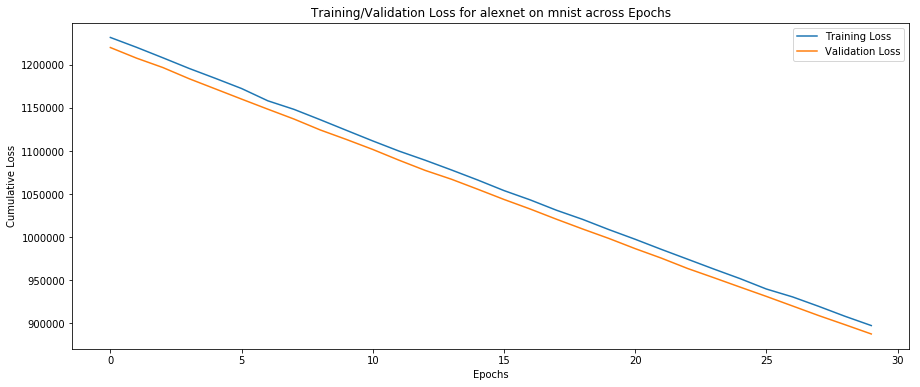

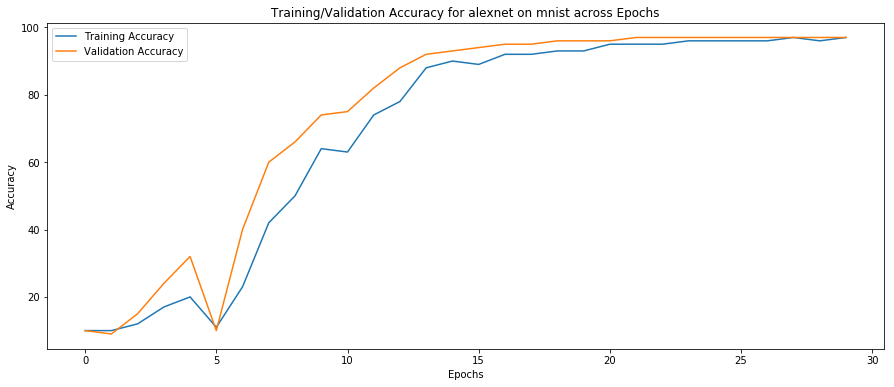

In [0]:
#@title
def plot_loss():
  fig = plt.figure(figsize=(15,6))
  plt.plot(np.arange(len(train_losses)), train_losses, label='Training Loss')
  plt.plot(np.arange(len(val_losses)), val_losses, label='Validation Loss')
  plt.title('Training/Validation Loss for {} on {} across Epochs'.format(net_type, dataset))
  plt.xlabel('Epochs')
  plt.ylabel('Cumulative Loss')
  plt.legend()
  
def plot_acc():
  fig = plt.figure(figsize=(15,6))
  plt.plot(np.arange(len(train_accs)), train_accs, label='Training Accuracy')
  plt.plot(np.arange(len(val_accs)), val_accs, label='Validation Accuracy')
  plt.title('Training/Validation Accuracy for {} on {} across Epochs'.format(net_type, dataset))
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  
plot_loss()
plot_acc()

We can take a look at the model predictions
For Classification tasks only.

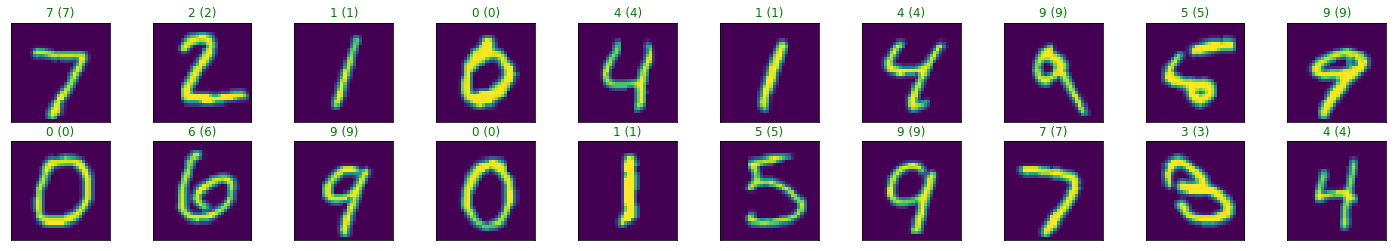

In [0]:
#@title
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    img_transposed = np.transpose(img, (1, 2, 0))
    plt.imshow(img_transposed.squeeze())  # convert from Tensor image
    
def visualize_predictions():
  # obtain one batch of test images
  dataiter = iter(testloader)
  images, labels = dataiter.next()
  images.numpy()

  # move model inputs to cuda, if GPU available
  if use_cuda:
    images = images.cuda()

  # get sample outputs
  output, kl = net.probforward(images)
  # convert output probabilities to predicted class
  _, preds_tensor = torch.max(output, 1)
  preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())

  # plot the images in the batch, along with predicted and true labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
    

if not regression:
  visualize_predictions()

Lets specifically look for cases where the model makes an incorrect prediction. We can pick those examples and see how the predictive distribution looks like for the different epochs.

Batch 0, Image 247 - prediction 6, label 4
Batch 0, Image 259 - prediction 0, label 6
Batch 0, Image 290 - prediction 4, label 8
Batch 0, Image 320 - prediction 8, label 9
Batch 0, Image 340 - prediction 1, label 5
Batch 0, Image 449 - prediction 5, label 3
Batch 0, Image 495 - prediction 0, label 8
Batch 0, Image 571 - prediction 9, label 4
Batch 0, Image 582 - prediction 2, label 8
Batch 0, Image 659 - prediction 1, label 2
Batch 0, Image 684 - prediction 3, label 7
Batch 0, Image 720 - prediction 6, label 5
Batch 0, Image 726 - prediction 9, label 7
Batch 0, Image 740 - prediction 9, label 4
Batch 0, Image 846 - prediction 9, label 7
Batch 0, Image 924 - prediction 7, label 2
Batch 0, Image 947 - prediction 9, label 8
Batch 0, Image 965 - prediction 0, label 6
Batch 0, Image 1014 - prediction 5, label 6
Batch 1, Image 9 - prediction 1, label 8
Batch 1, Image 15 - prediction 2, label 7
Batch 1, Image 48 - prediction 5, label 3
Batch 1, Image 83 - prediction 5, label 9
Batch 1, Image 

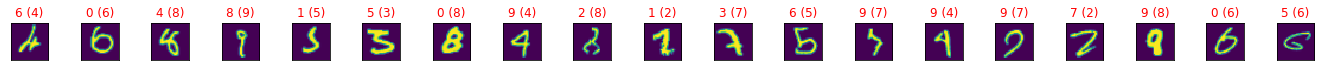

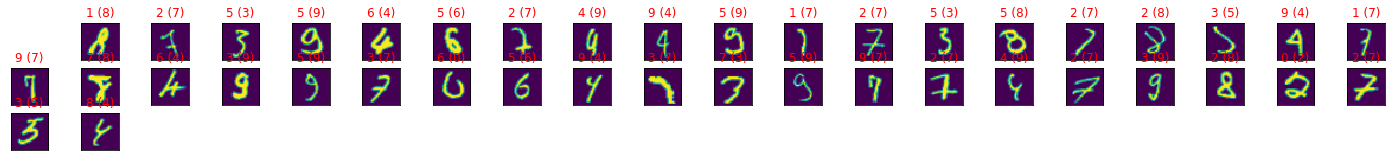

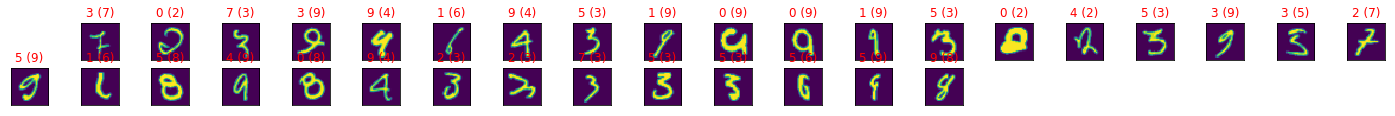

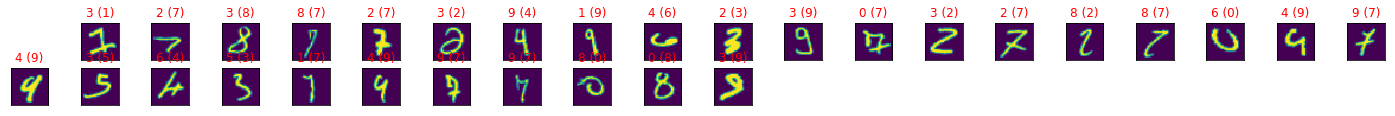

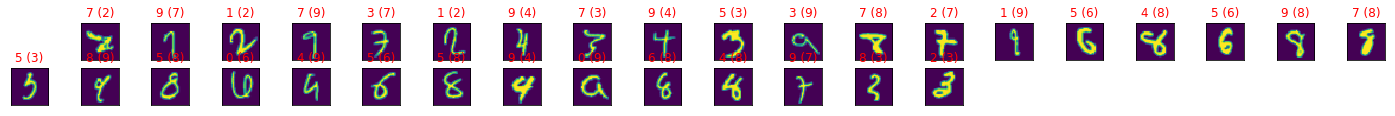

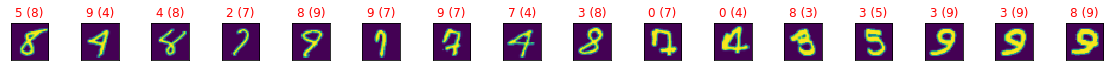

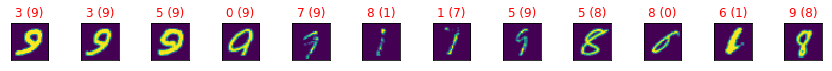

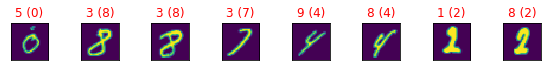

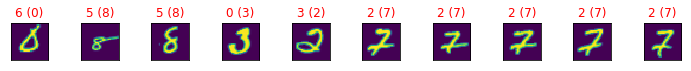

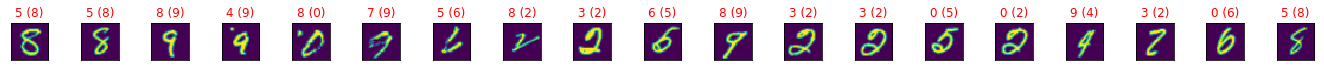

In [0]:
for batch_idx, (images, labels) in enumerate(testloader):
  images.numpy()

  # move model inputs to cuda, if GPU available
  if use_cuda:
    images = images.cuda()

  # get sample outputs
  output, kl = net.probforward(images)
  # convert output probabilities to predicted class
  _, preds_tensor = torch.max(output, 1)
  preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())

  # plot the images in the batch, along with predicted and true labels
  fig = plt.figure(figsize=(25, 4))
  n = len(images)
  ct = 1
  for idx in np.arange(n):
    if preds[idx] != labels[idx]: #prediction doesn't match label
      print('Batch {}, Image {} - prediction {}, label {}'.format(batch_idx, idx, preds[idx], labels[idx]))
      ax = fig.add_subplot(5, 20, ct+1, xticks=[], yticks=[])
      imshow(images[idx].cpu())
      ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                   color=("green" if preds[idx]==labels[idx].item() else "red"))
      ct += 1

During the run, the following images had incorrect predictions. These maybe different on a next run.

Lets grab some images with incorrect predictions.

In [0]:
def grab_images_from_batches(batch_img_dict):
  batch_ret_dict = {}
  for batch_idx, (images, labels) in enumerate(testloader):
    images.numpy()
    if batch_idx in batch_img_dict:
      batch_ret_dict[batch_idx] = {}
      for idx in batch_img_dict[batch_idx]:
        batch_ret_dict[batch_idx][idx] = images[idx]
  return batch_ret_dict

In [0]:
batch_img_dict = grab_images_from_batches({2: [332]})

In [0]:
img = batch_img_dict[2][332]

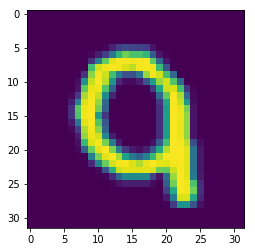

In [0]:
imshow(img)

Lets load all the saved models for different epochs

In [0]:
def load_states():
  states = []
  for epoch in saved_epochs:
    filename = './checkpoint-{}-{}-epoch-{}.pt'.format(net_type, dataset, epoch)
    state = torch.load(filename)
    states.append(state)
  return states

states = load_states()

In [0]:
nets = [state['net'] for idx, state in enumerate(states) if idx%1 == 0]
epochs = [state['epoch'] for idx, state in enumerate(states) if  idx%1 == 0]

Here we try to obtain a sample of predictions for a given input and overlay them on the same graph - essentially plotting a histogram for the softmax output corresponding to each class.

This function takes an image and samples it `n_iter` (default 1000) times through model for given epoch.

In [0]:
def sample_predictive_epoch(img, epoch, n_iter=1000):
  batch_size = n_iter
  shape = img.shape
  im_rep = np.repeat(img, batch_size, 0).reshape(batch_size, shape[0], shape[1], shape[2])
  outs, kl = nets[epoch].probforward(im_rep.cuda())
  preds = F.softmax(outs, dim=1)
  outputs = preds.detach().cpu().numpy()
  #outputs = normalize(softplus(outs.detach().cpu().numpy()), axis=1, norm='l1')
  
  return outputs
  

Its a little tricky to plot the distributions since they can be at extreme ends (0 and 1) with high pdf and small variation. The functions below plots all classes on a single axes, or use two different axes to zoom in on the distributions. The x axis limits help control the scale and visualize the spread of the distribution.

In [0]:
def single_ax_plot(outputs, epoch, n_classes=10, xlim=(-0.1, 1.1), ylim=(0, 100)):
  fig, ax = plt.subplots(figsize=(15,6))
  for i in range(n_classes):
    sns.distplot(outputs[:, i], ax=ax, label='Class {}'.format(i), kde=False, hist=True, bins=100)

  ax.set_xlim(xlim)#0 - 1e-1, 1 + 1e-1)
  #ax2.set_xlim(1 - 5e-4, 1 + 1e-4)
  ax.set_ylim(ylim)
  phat = np.max(outputs, axis=1)
  confidence_mean = np.mean(phat, axis=0)
  confidence_var = np.var(phat, axis=0)
  epistemic = np.mean(phat**2, axis=0) - np.mean(phat, axis=0)**2
  aleatoric = np.mean(phat*(1-phat), axis=0)
  plt.legend()
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  fig.suptitle('Sampled Predictive Distribution for Epoch {}. Average Confidence = {:.2f}, variance = {:.4g}, epistemic uncertainty = {:.4g}, aleatoric uncertainty = {:.4g}'.format(epoch, confidence_mean, confidence_var, epistemic, aleatoric))

In [0]:
def broken_ax_plot(outputs, epoch, ax1_xlim, ax2_xlim, n_classes=10, ylim=(0, 100)):
  fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, facecolor='w', figsize=(15,6))
  for i in range(n_classes):
    sns.distplot(outputs[:, i], ax=ax1, label='Class {}'.format(i), kde=False, hist=True, bins=100)
    sns.distplot(outputs[:, i], ax=ax2, label='Class {}'.format(i), kde=False, hist=True, bins=100)

  ax1.set_xlim(ax1_xlim)
  ax2.set_xlim(ax2_xlim)
  ax1.set_ylim(ylim)
  # hide the spines between ax and ax2
  ax1.spines['right'].set_visible(False)
  ax2.spines['left'].set_visible(False)
  ax1.yaxis.tick_left()
  ax1.tick_params(labelright=False)
  ax2.yaxis.tick_right()

  #Ref - https://stackoverflow.com/questions/32185411/break-in-x-axis-of-matplotlib
  # This looks pretty good, and was fairly painless, but you can get that
  # cut-out diagonal lines look with just a bit more work. The important
  # thing to know here is that in axes coordinates, which are always
  # between 0-1, spine endpoints are at these locations (0,0), (0,1),
  # (1,0), and (1,1).  Thus, we just need to put the diagonals in the
  # appropriate corners of each of our axes, and so long as we use the
  # right transform and disable clipping.

  d = .015 # how big to make the diagonal lines in axes coordinates
  # arguments to pass plot, just so we don't keep repeating them
  kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
  ax1.plot((1-d,1+d), (-d,+d), **kwargs)
  ax1.plot((1-d,1+d),(1-d,1+d), **kwargs)

  kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
  ax2.plot((-d,+d), (1-d,1+d), **kwargs)
  ax2.plot((-d,+d), (-d,+d), **kwargs)
  
  phat = np.max(outputs, axis=1)
  confidence_mean = np.mean(phat, axis=0)
  confidence_var = np.var(phat, axis=0)
  epistemic = np.mean(phat**2, axis=0) - np.mean(phat, axis=0)**2
  aleatoric = np.mean(phat*(1-phat), axis=0)
  plt.legend()
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  fig.suptitle('Sampled Predictive Distribution for Epoch {}. Average Confidence = {:.2f}, variance = {:.4g}, epistemic uncertainty = {:.4g}, aleatoric uncertainty = {:.4g}'.format(epoch, confidence_mean, confidence_var, epistemic, aleatoric))

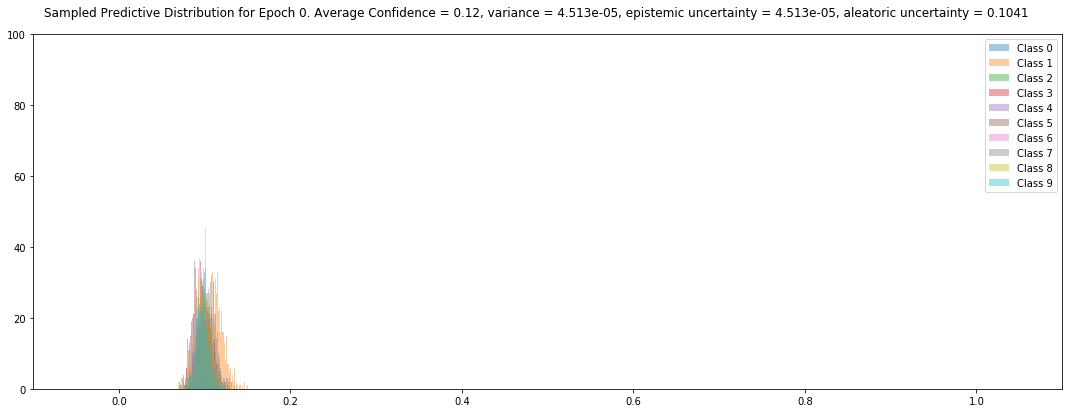

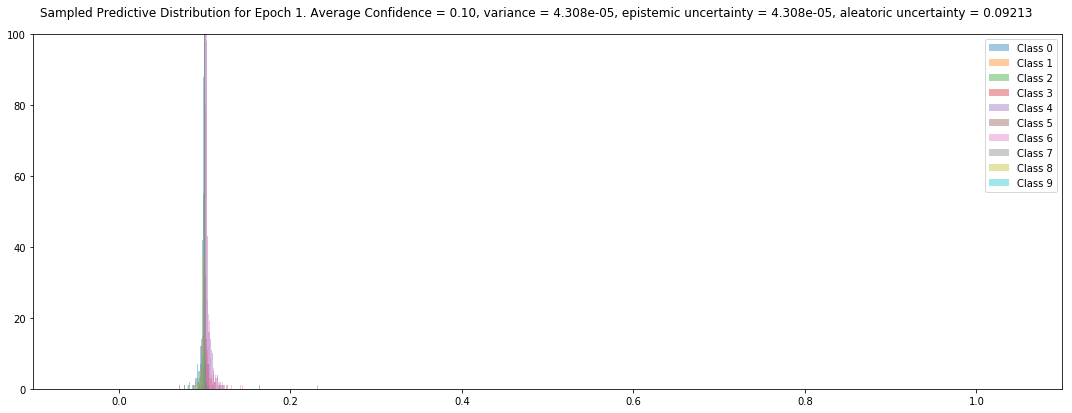

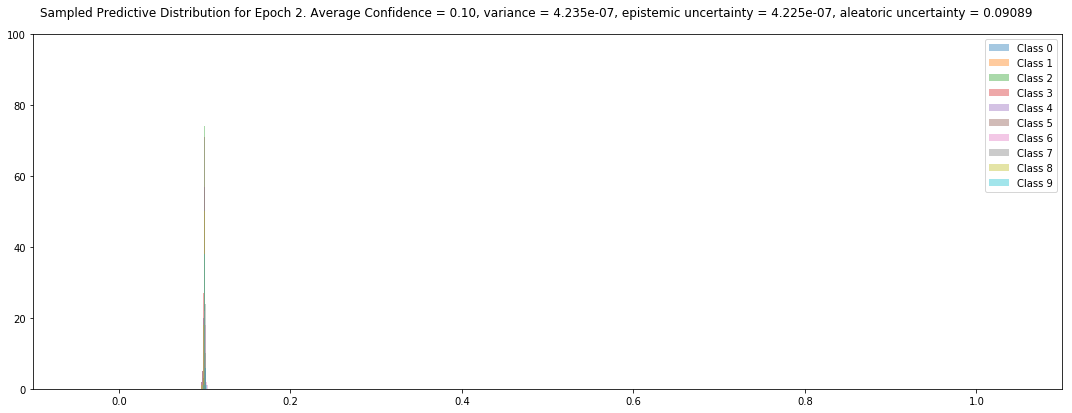

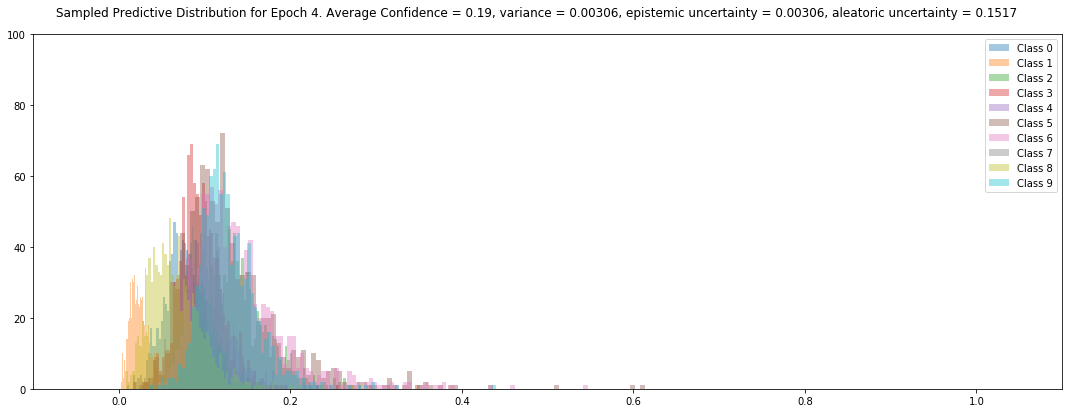

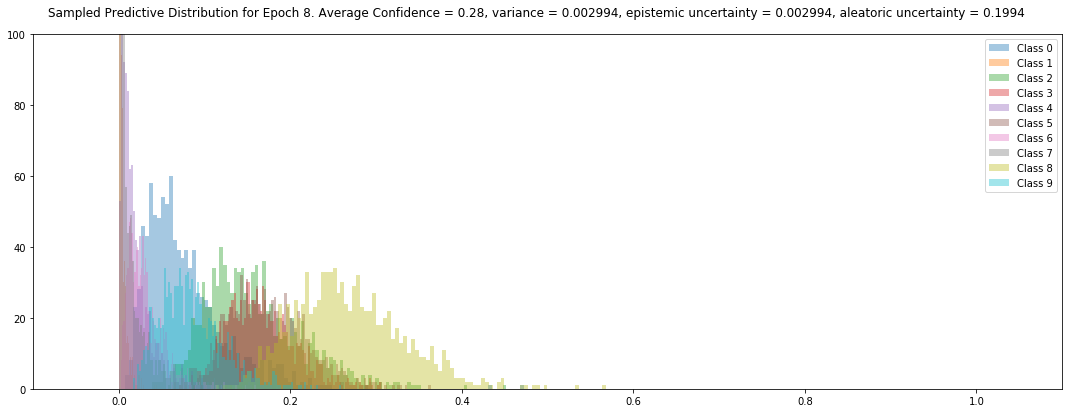

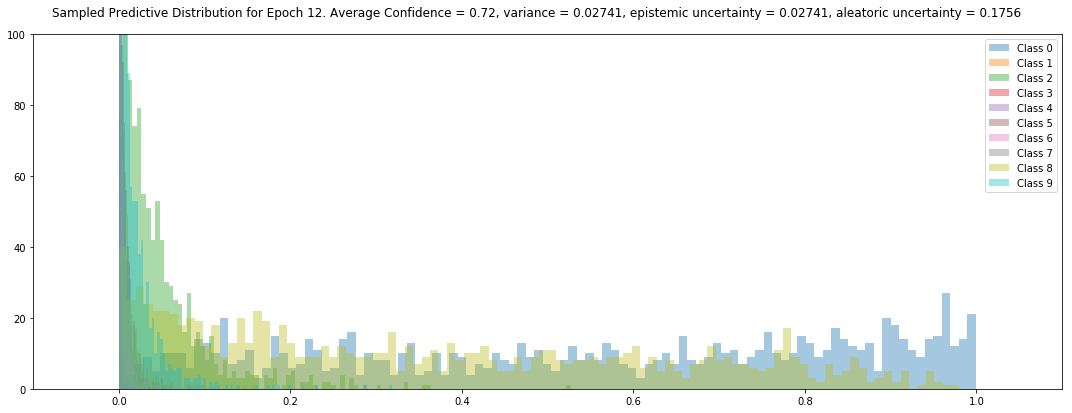

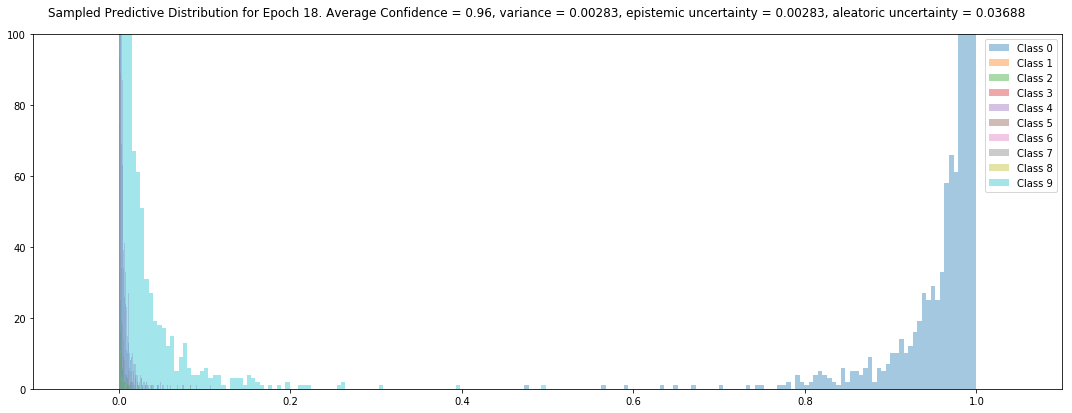

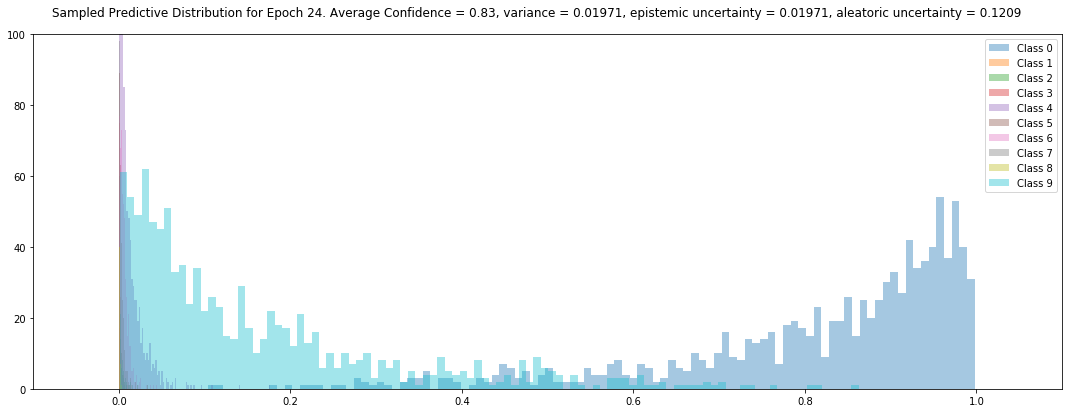

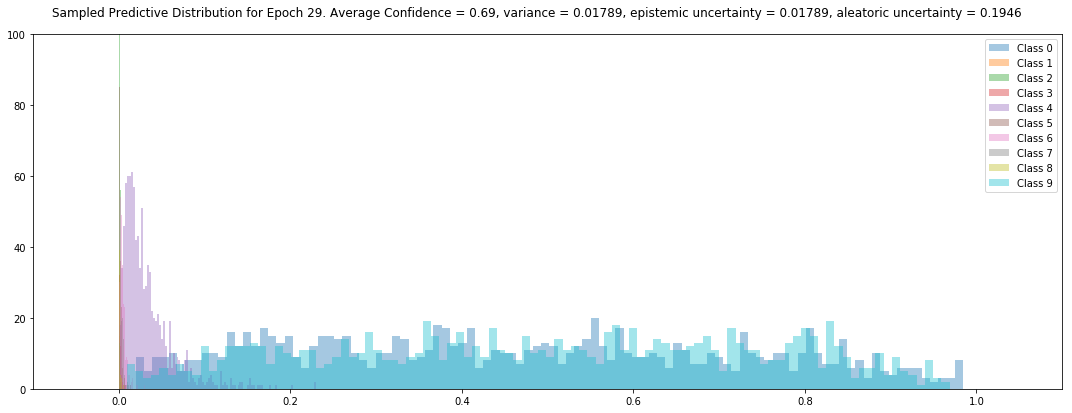

In [0]:
for i in [0, 1, 2, 4, 8, 12, 18, 24, 29]:
  outputs = sample_predictive_epoch(img, i)
  #if i < 3:
  #  xlim1, xlim2 = ((0.1 - 0.001, 0.101 ), (0.102, 1)) if i == 1 else ((0.1 - 0.01, 0.11 ), (0.12, 1)) #change as necessary to zoom in on the distribution
  #  broken_ax_plot(outputs, i, xlim1, xlim2)
  #else:  
  xlim = (-0.1, 1.1) #change as necessary to zoom in on the distribution
  single_ax_plot(outputs, i, xlim=xlim)

The variance of the variational approximation to the posterior predictive distribution is estimated by the following formula

$
\begin{align*}
Var_{q_\theta(y^*|x^*)}(y^*) &= E_{q_\hat{\theta}(y^*|x^*)}\{y^{*\otimes 2}\} -  E_{q_\hat{\theta}(y^*|x^*)}(y)^{*\otimes 2}\\
&= \underbrace{\int_\Omega [diag\{E_{p(y^*|x^*, \omega)}(y^*)\} - E_{p(y^*|x^*, \omega)}(y^*)^{\otimes 2}] q_\hat{\theta}(\omega) d\omega}_\text{aleatoric}\\
&+ \underbrace{\int_\Omega\{E_{p(y^*|x^*, \omega)}(y^*) - E_{q_\hat{\theta}(y^*|x^*)}(y^*)\}^{\otimes 2}q_\hat{\theta}(\omega) d\omega}_\text{epistemic} 
\end{align*}
$

See [Kwon et. al](https://openreview.net/pdf?id=Sk_P2Q9sG) for a proof. The important thing is the replacement of 
$E_{p(y^*|x^*, \omega)}(y^{* \otimes 2})$ with $diag\{E_{p(y^*|x^*, \omega)}(y^*)\}$ which is valid under the assumption that $y^*$ is one-hot encoded, in other words the true label would look like a one-hot encoded vector.

We can still use $\hat{p}_t = p(\hat{\omega}_t) = \text{Softmax}(f^{\hat{\omega}_t}(x^*))$ to approximate $diag\{E_{p(y^*|x^*, \omega)}(y^*)\}$. As the model becomes more confident, it is expected that its prediction would look like a one-hot vector.

If we the mean prediction $\bar{p} = \sum^T_{t=1} \frac{\hat{p}_t}{T}$ to approximate the expected posterior predictive output $ E_{q_\hat{\theta}(y^*|x^*)}(y^*)$, then we can use the following Monte-Carlo approximation to the above intractable integrals.

$
\begin{align*}
Var_{q_\theta(y^*|x^*)}(y^*) = \underbrace{\frac{1}{T} \sum_{t=1}^T diag(\hat{p}_t) - \hat{p}_t^{\otimes 2}}_\text{aleatoric} + \underbrace{\frac{1}{T} \sum_{t=1}^T (\hat{p}_t - \bar{p})^{\otimes 2}}_\text{epistemic}
\end{align*}
$

The first term above reflects how different the average output prediction is from what the true label should look like (a one-hot encoded vector).
The second term reflects how different the predictions are from each other.

Doing an `np.cov(` $\hat{p}_t$ `)` to compute covariance matrix only considers how different the predictions are from each other, not how different they are from the expect true label. Hence the confidence variance term above is only equal to the epistemic uncertainty, and not the full predictive variance.

The scalar values of the uncertainties above are computed by taking the highest prediction probability for each prediction.
We can also take the full vector of probabilities compute the covariance matrix as well as matrices for uncertainties. Lets do it for one epoch.

In [0]:
outputs = sample_predictive_epoch(img, epoch=10)

In [0]:
output_mean = np.mean(outputs, axis=0)

In [0]:
epistemic = np.mean(np.apply_along_axis(lambda pred: np.outer(pred - output_mean, pred - output_mean), 1, outputs), axis=0) 

In [0]:
aleatoric = np.mean(np.apply_along_axis(lambda pred: np.diag(pred) - np.outer(pred, pred), 1, outputs ), axis=0)

In [0]:
covariance_matrix = np.cov(outputs, rowvar=False)

In [0]:
epistemic

array([[ 9.42383148e-03, -6.79980894e-06, -1.71989831e-03,
         7.27816587e-05, -6.75881238e-05, -1.43853517e-03,
        -1.02421164e-03,  1.92742416e-04, -5.03735617e-03,
        -3.94970499e-04],
       [-6.79980894e-06,  1.67590988e-04, -6.09079907e-05,
        -2.88042320e-05,  6.18421564e-06, -6.33574527e-05,
         1.27058311e-05,  2.12911655e-05, -9.94255097e-05,
         5.15228639e-05],
       [-1.71989831e-03, -6.09079907e-05,  2.43676151e-03,
         6.81566817e-05, -1.70304884e-05,  9.89029184e-04,
         4.06934356e-04, -2.23043491e-04, -1.35367899e-03,
        -5.26325952e-04],
       [ 7.27816587e-05, -2.88042320e-05,  6.81566817e-05,
         9.96462069e-04, -1.44494643e-05,  1.05506471e-04,
        -9.23483021e-05, -1.85261561e-05, -9.61939979e-04,
        -1.26839717e-04],
       [-6.75881238e-05,  6.18421564e-06, -1.70304884e-05,
        -1.44494643e-05,  7.53500644e-05, -1.36911913e-05,
         2.39827968e-05,  6.54546284e-06, -3.34457036e-05,
         3.

In [0]:
aleatoric

array([[ 1.2862593e-01, -2.2157009e-03, -1.9350201e-02, -7.6200669e-03,
        -1.5900329e-03, -1.6882950e-02, -5.1588109e-03, -2.7265323e-03,
        -6.1734848e-02, -1.1346924e-02],
       [-2.2157009e-03,  1.3088147e-02, -1.6506147e-03, -5.8426068e-04,
        -1.4083253e-04, -1.4248947e-03, -5.1495183e-04, -2.2711061e-04,
        -5.3244708e-03, -1.0053153e-03],
       [-1.9350201e-02, -1.6506147e-03,  1.0871801e-01, -5.8802301e-03,
        -1.2594829e-03, -1.5098174e-02, -5.1684002e-03, -1.7281966e-03,
        -5.0066747e-02, -8.5159643e-03],
       [-7.6200669e-03, -5.8426068e-04, -5.8802301e-03,  4.2549253e-02,
        -4.4279633e-04, -5.1593916e-03, -1.6132036e-03, -6.8040588e-04,
        -1.7456805e-02, -3.1120968e-03],
       [-1.5900329e-03, -1.4083253e-04, -1.2594829e-03, -4.4279633e-04,
         9.8454878e-03, -1.0963011e-03, -3.9857597e-04, -1.6005305e-04,
        -4.0118946e-03, -7.4551470e-04],
       [-1.6882950e-02, -1.4248947e-03, -1.5098174e-02, -5.1593916e-03,
   

In [0]:
covariance_matrix

array([[ 9.43326709e-03, -6.80662429e-06, -1.72161921e-03,
         7.28545159e-05, -6.76557769e-05, -1.43997423e-03,
        -1.02523700e-03,  1.92935210e-04, -5.04239777e-03,
        -3.95366143e-04],
       [-6.80662429e-06,  1.67758809e-04, -6.09689479e-05,
        -2.88330552e-05,  6.19040884e-06, -6.34208913e-05,
         1.27185534e-05,  2.13124869e-05, -9.95251116e-05,
         5.15743995e-05],
       [-1.72161921e-03, -6.09689479e-05,  2.43920309e-03,
         6.82248893e-05, -1.70475391e-05,  9.90019111e-04,
         4.07341924e-04, -2.23266839e-04, -1.35503361e-03,
        -5.26852816e-04],
       [ 7.28545159e-05, -2.88330552e-05,  6.82248893e-05,
         9.97460401e-04, -1.44639281e-05,  1.05612191e-04,
        -9.24407151e-05, -1.85447324e-05, -9.62902882e-04,
        -1.26966690e-04],
       [-6.76557769e-05,  6.19040884e-06, -1.70475391e-05,
        -1.44639281e-05,  7.54254429e-05, -1.37048988e-05,
         2.40068087e-05,  6.55201436e-06, -3.34792031e-05,
         3.

The negative uncertainties probably represent anti-correlation.

We can also replace the softmax with a normalized softplus, which in fact is highlighted as a better approach by Shridhar et. al (although their code still implemented the softmax approach).

In [0]:
def softplus(x): 
  return np.log(1 + np.exp(x))

In [0]:
def sample_predictive_epoch_normalized_softplus(img, epoch, n_iter=1000):
  batch_size = n_iter
  shape = img.shape
  im_rep = np.repeat(img, batch_size, 0).reshape(batch_size, shape[0], shape[1], shape[2])
  outs, kl = nets[epoch].probforward(im_rep.cuda())
  outputs = normalize(softplus(outs.detach().cpu().numpy()), axis=1, norm='l1')
  
  return outputs
  

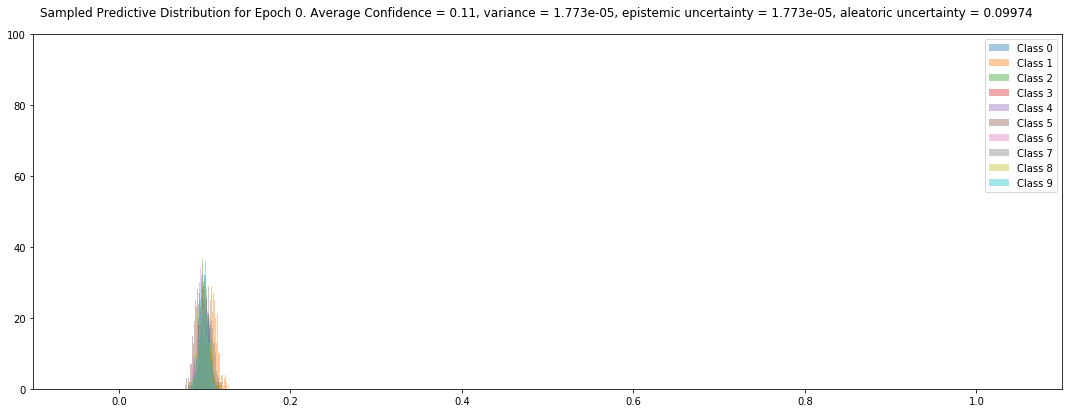

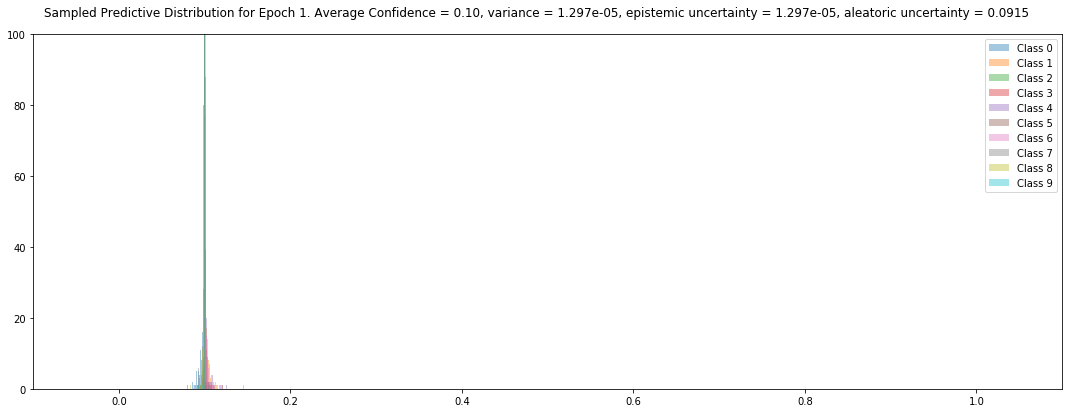

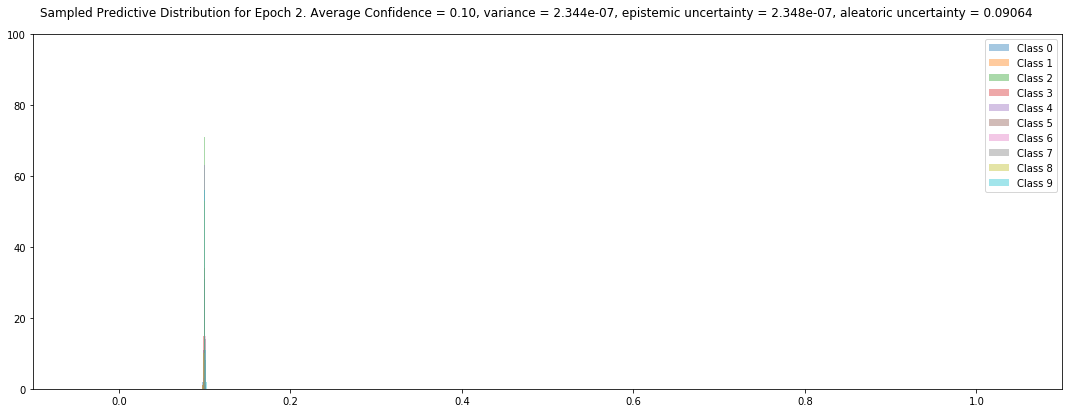

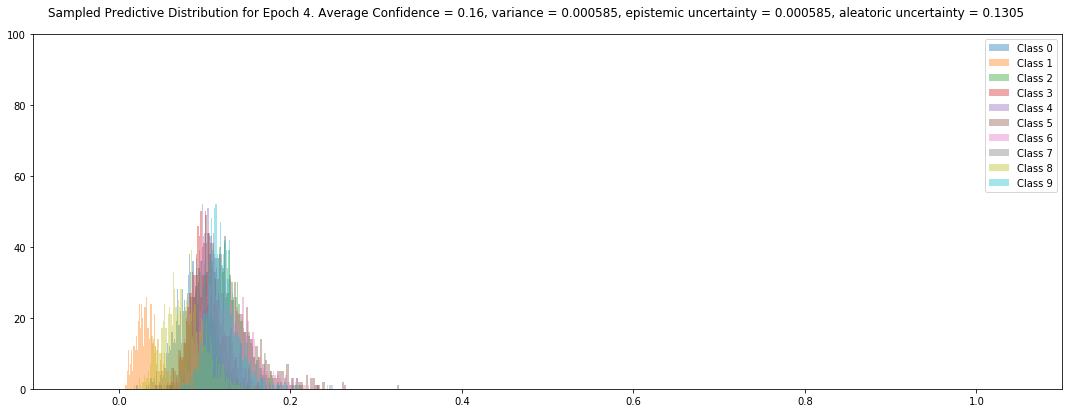

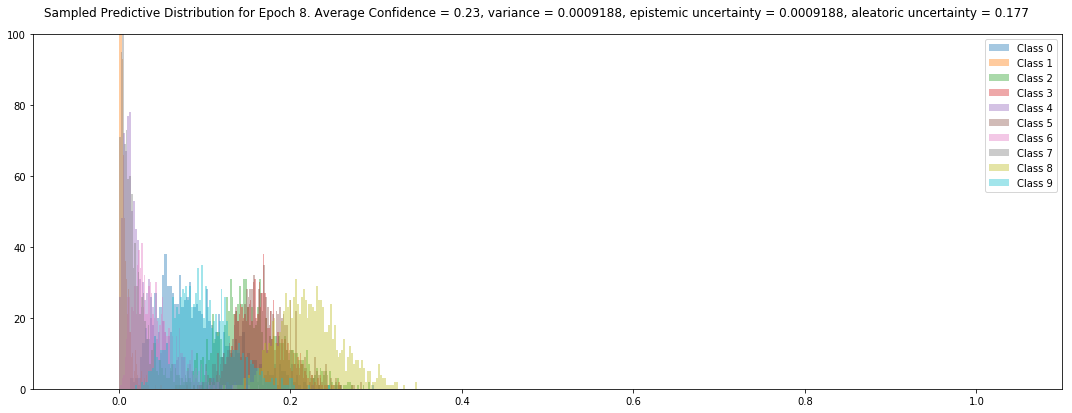

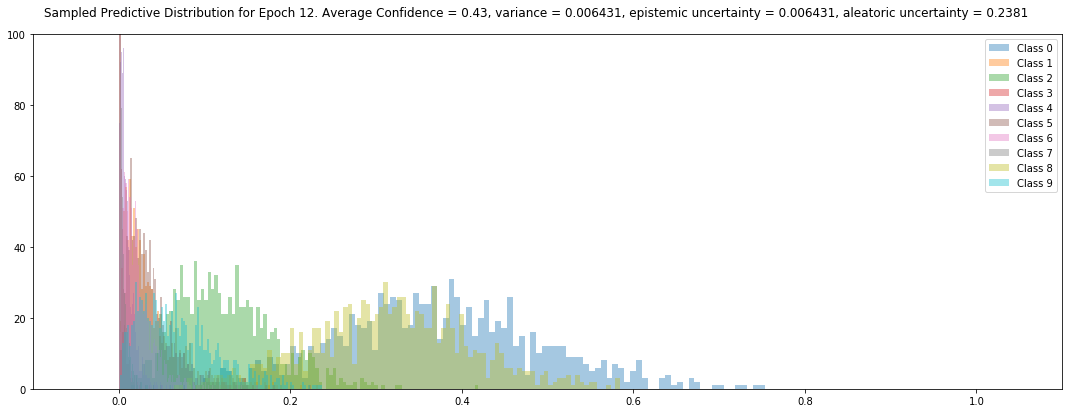

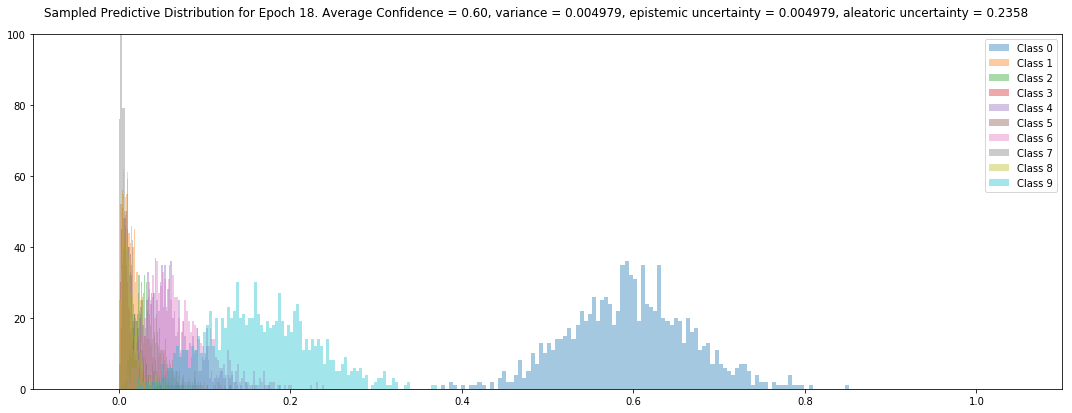

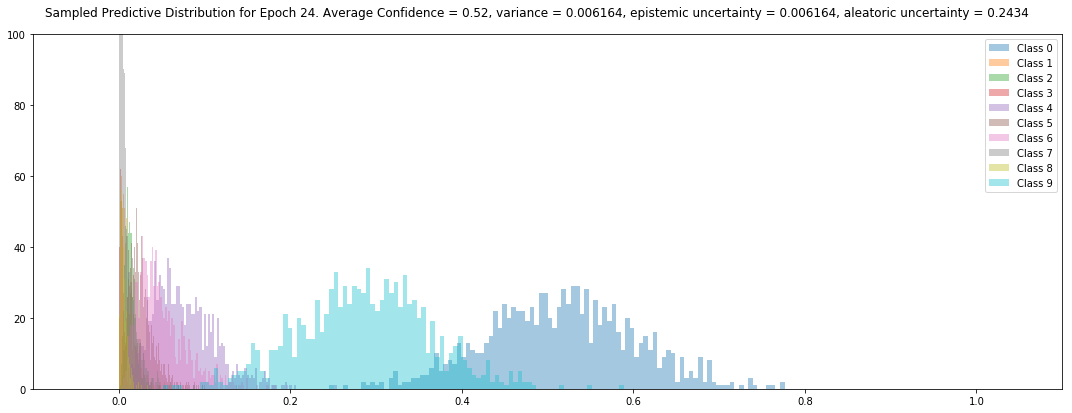

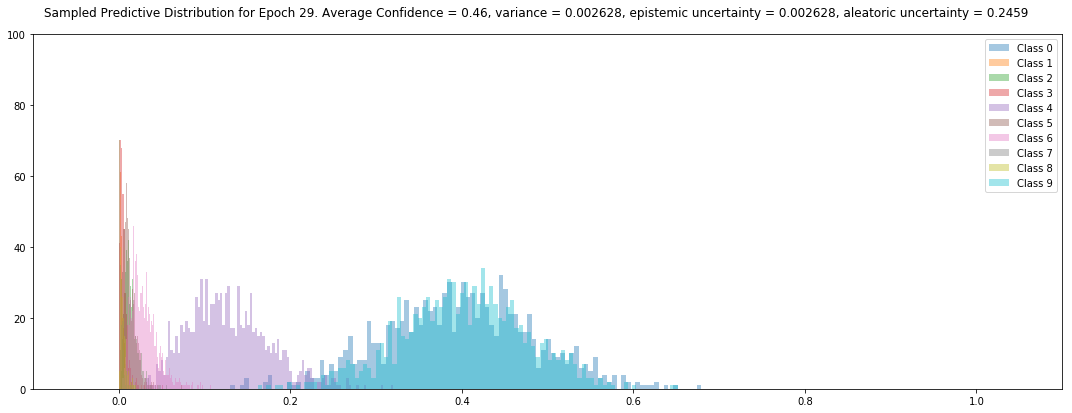

In [0]:
for i in [0, 1, 2, 4, 8, 12, 18, 24, 29]: #range(0, len(classes)):
  outputs = sample_predictive_epoch_normalized_softplus(img, i)
  #if i < 3:
  #  xlim1, xlim2 = ((0.1 - 0.001, 0.101 ), (0.102, 1)) if i == 1 else ((0.1 - 0.01, 0.11 ), (0.12, 1)) #change as necessary to zoom in on the distribution
  #  broken_ax_plot(outputs, i, xlim1, xlim2)
  #else:  
  xlim = (-0.1, 1.1) #change as necessary to zoom in on the distribution
  single_ax_plot(outputs, i, xlim=xlim)

We could try look at the a case where the network did well.

In [0]:
dataloader = iter(testloader)
images, labels = dataloader.next()

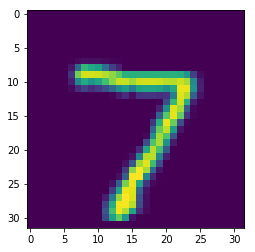

In [0]:
imshow(images[0])

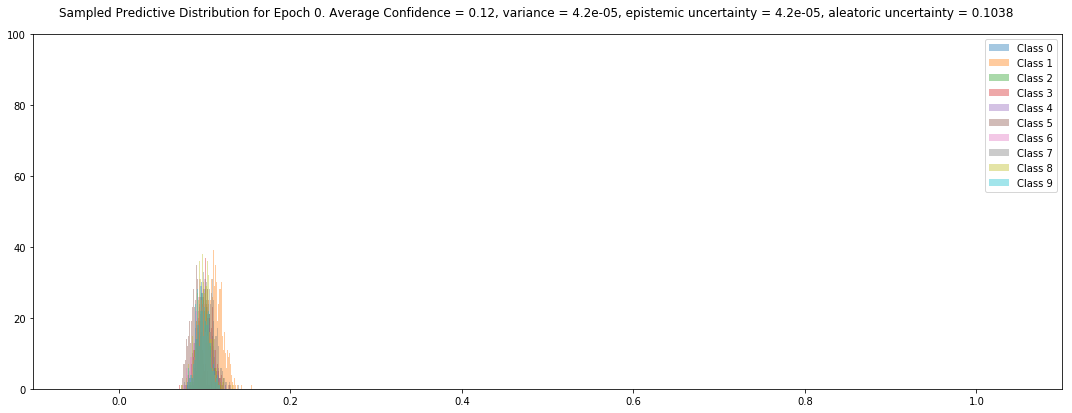

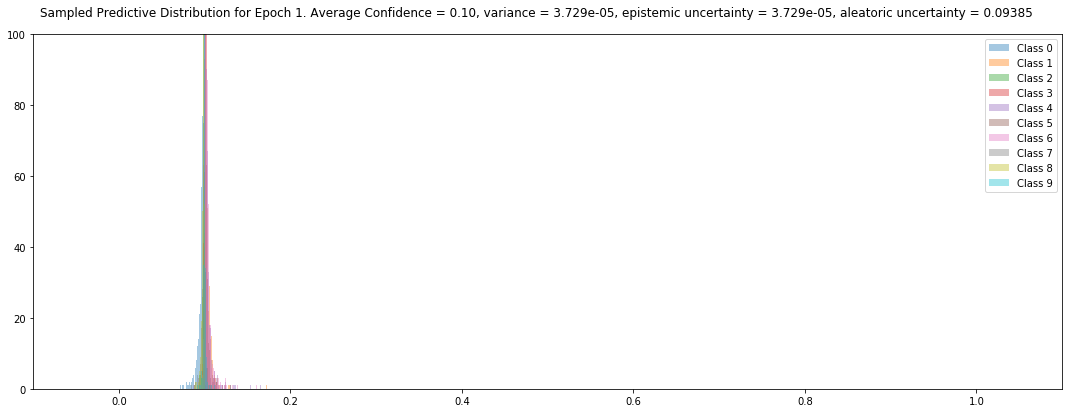

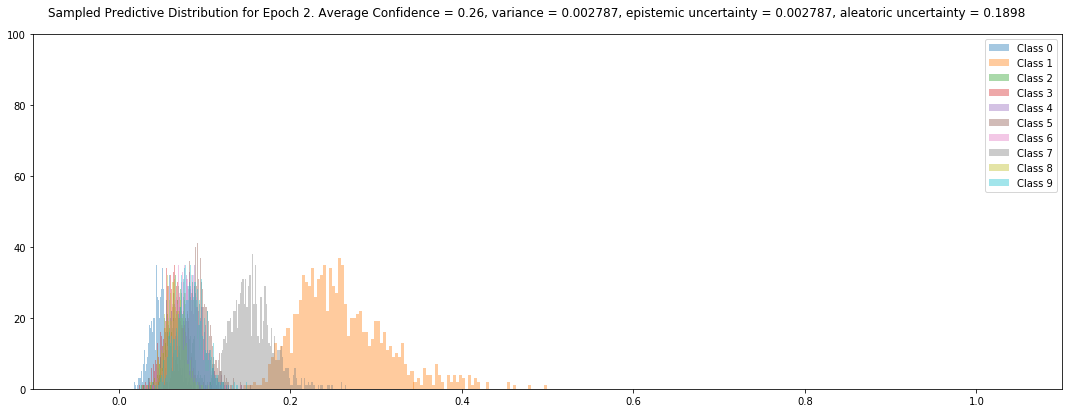

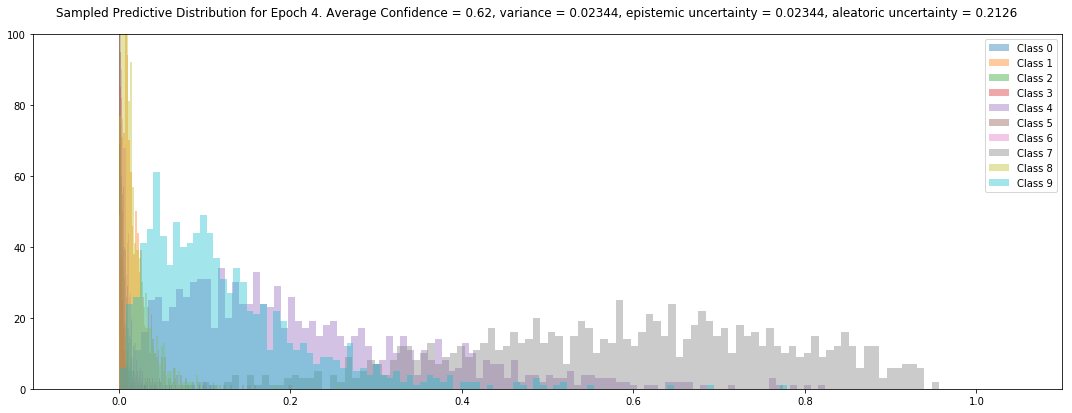

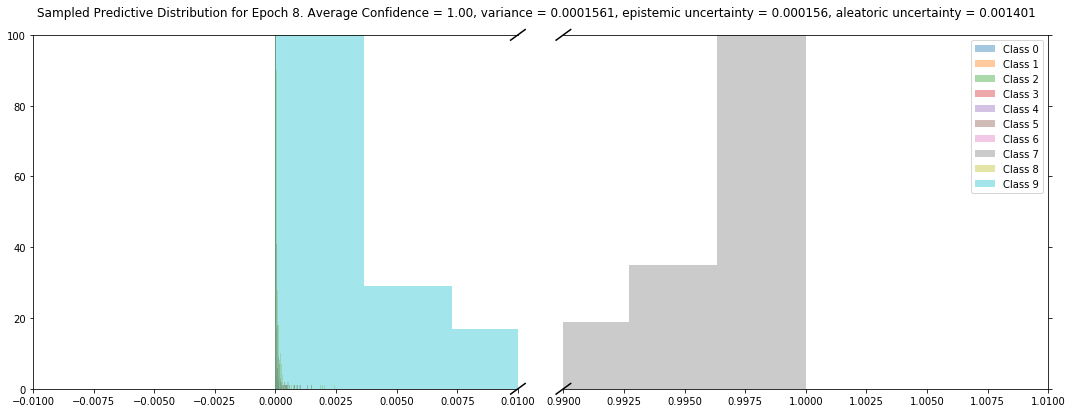

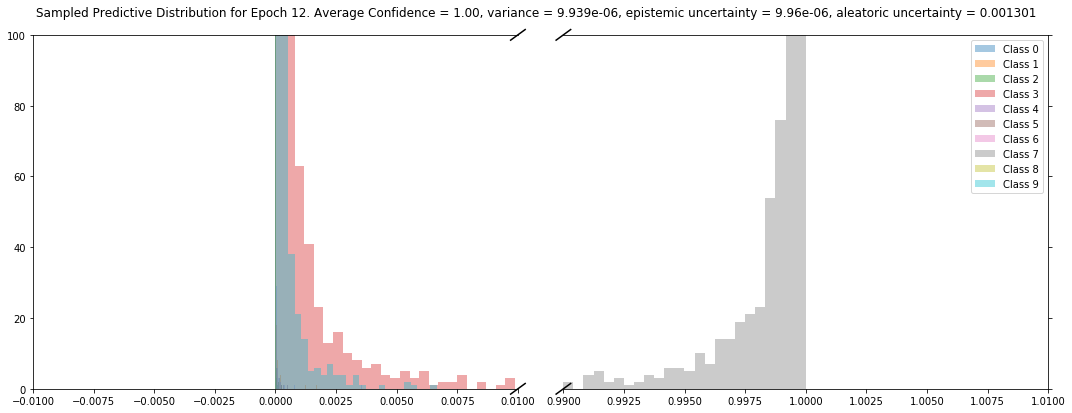

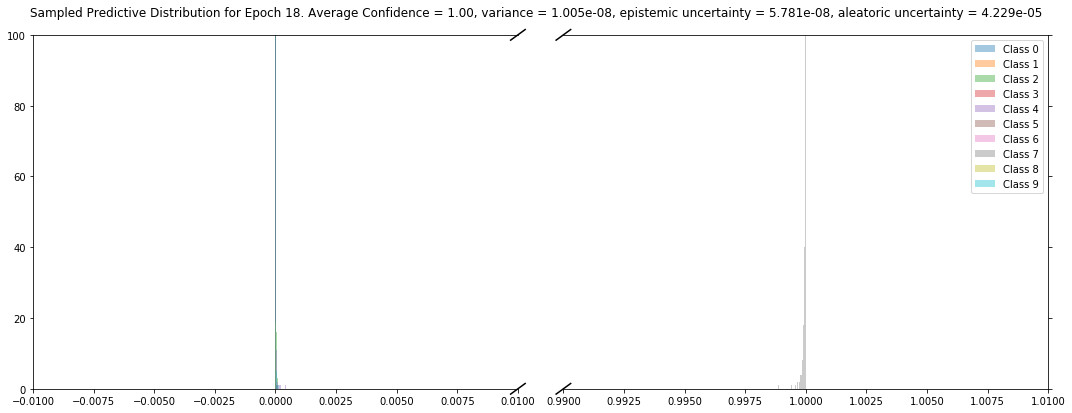

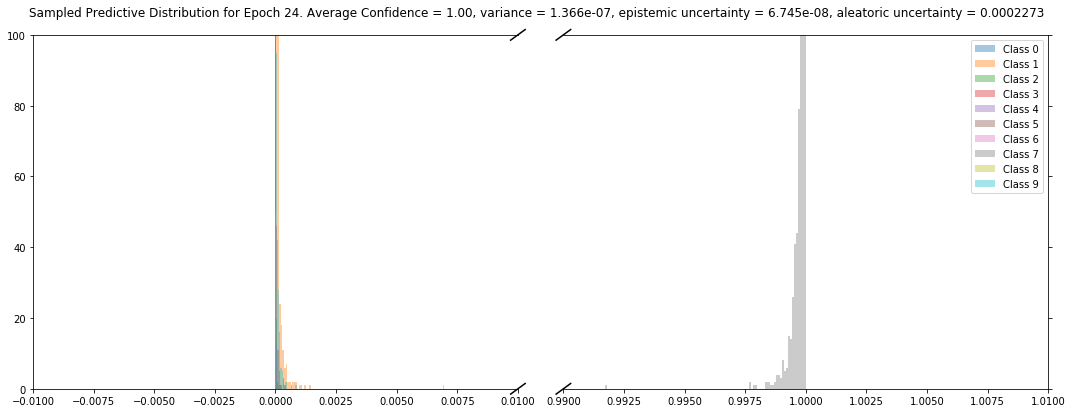

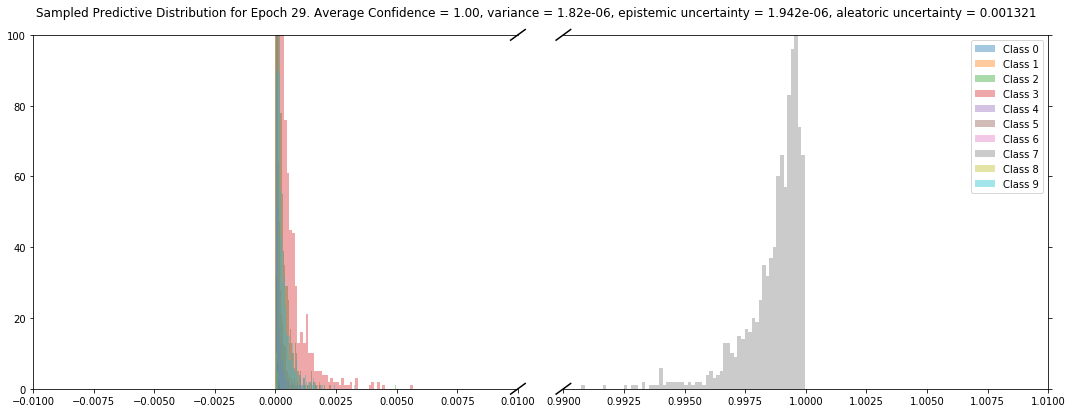

In [0]:
for i in [0, 1, 2, 4, 8, 12, 18, 24, 29]: #range(0, len(classes)):
  outputs = sample_predictive_epoch(images[0], i)
  xlim1, xlim2 = ((0.1 - 0.01, 0.11 ), (0.12, 1))
  '''if i < 0:
    xlim1, xlim2 = ((0.1 - 0.01, 0.11 ), (0.12, 1))  #change as necessary to zoom in on the distribution
    broken_ax_plot(outputs, i, xlim1, xlim2)
  elif i < 0:
    xlim1, xlim2 = ((0.1 - 1e-3, 0.1+1e-3 ), (0.1 + 2e-3, 1))
    broken_ax_plot(outputs, i, xlim1, xlim2)'''
  if i >= 0 and i < 8:
    #xlim1, xlim2 = ((0.1 - 5e-1, 0.1+5e-1 ), (0.1 + 5e-1, 1))
    single_ax_plot(outputs, i)
  else:
    xlim1, xlim2 = ((- 1e-2, 1e-2 ), (1 - 1e-2, 1 + 1e-2))
    broken_ax_plot(outputs, i, xlim1, xlim2)
  
  

Same input but with normalized softplus predictions

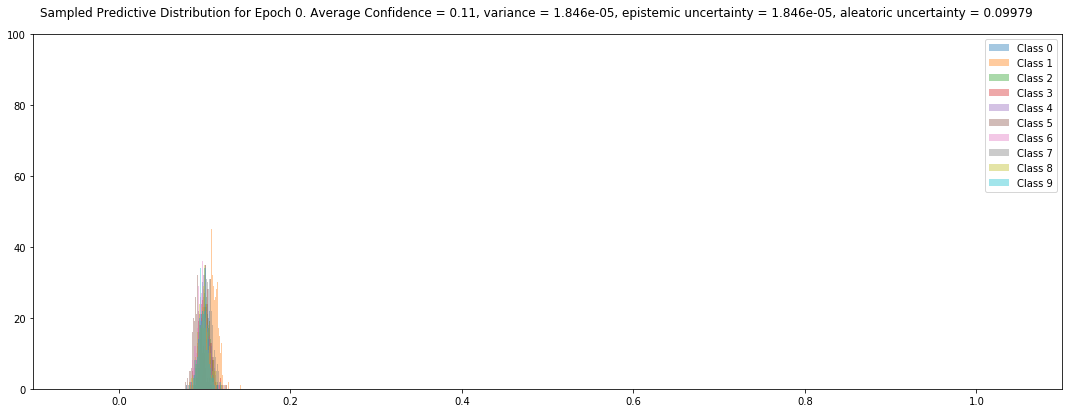

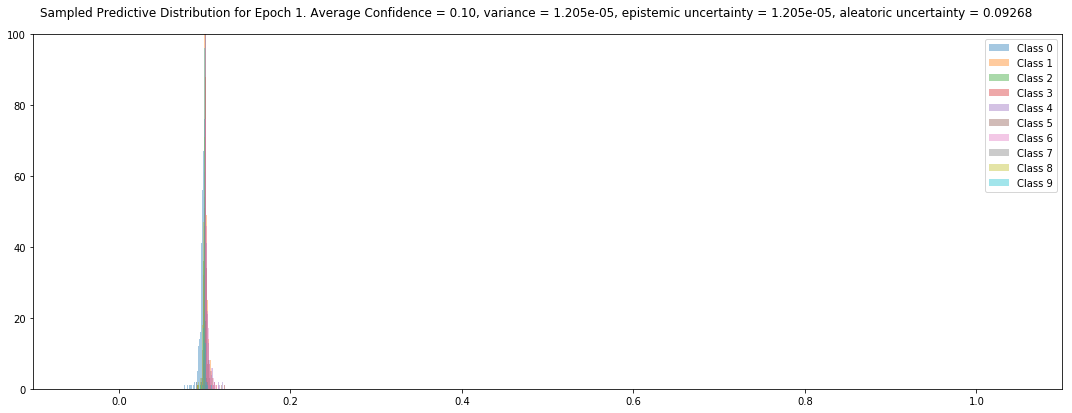

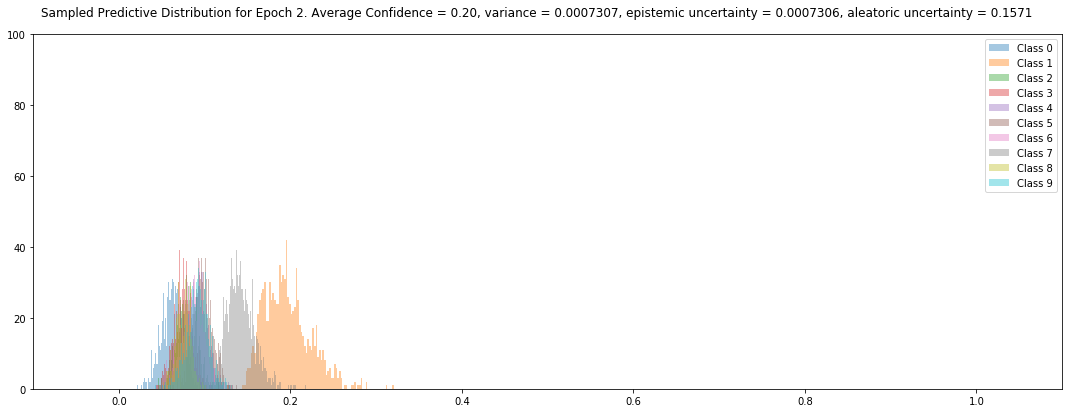

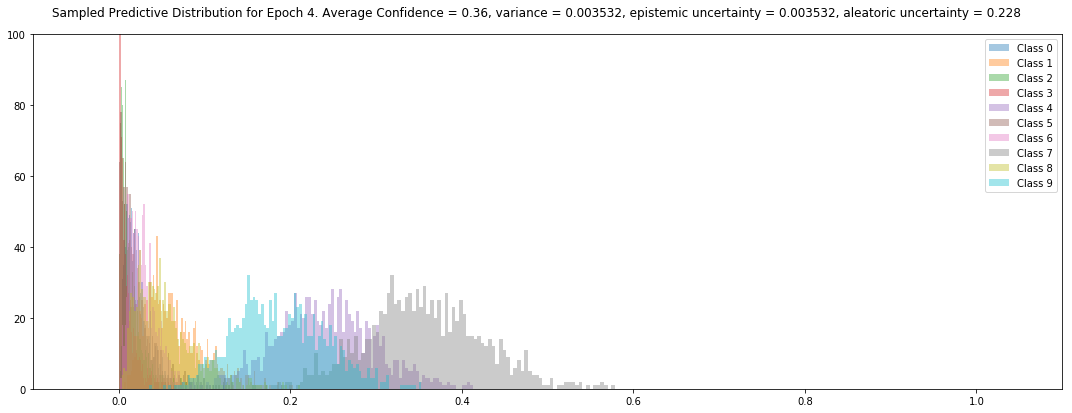

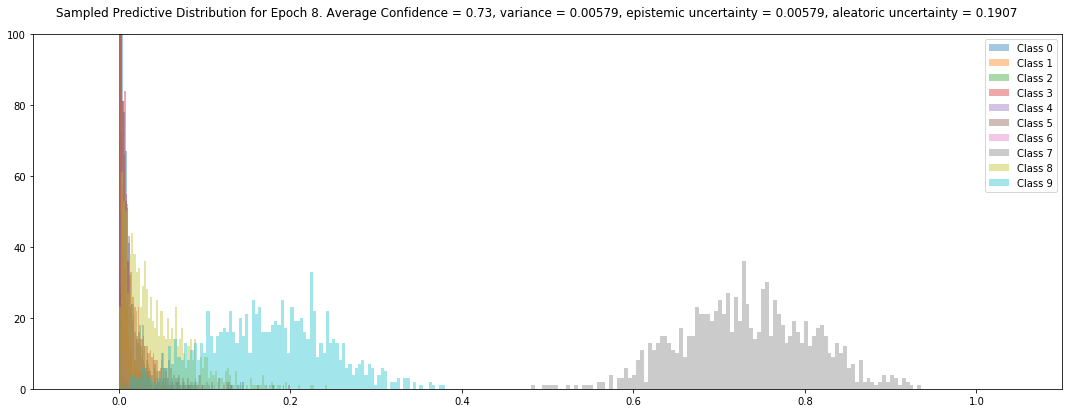

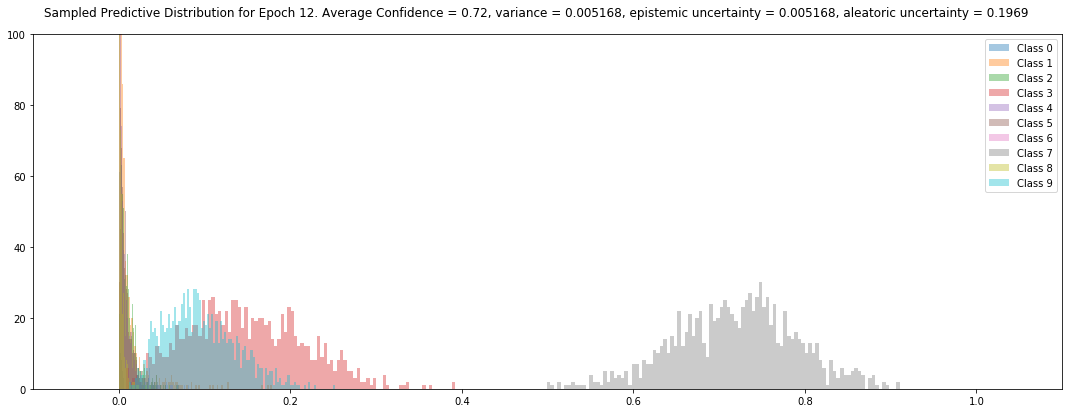

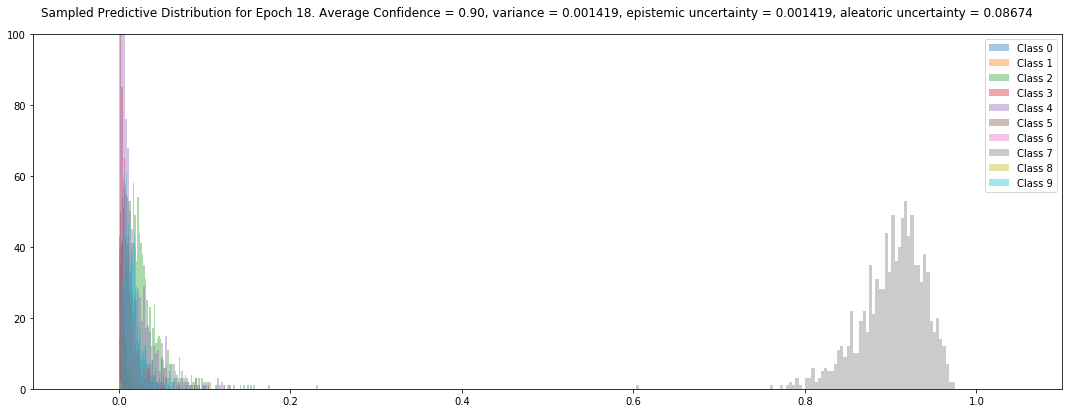

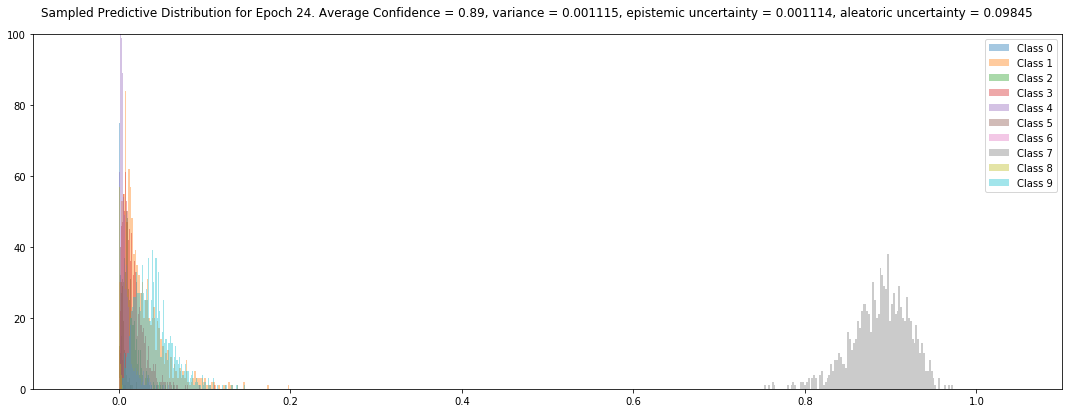

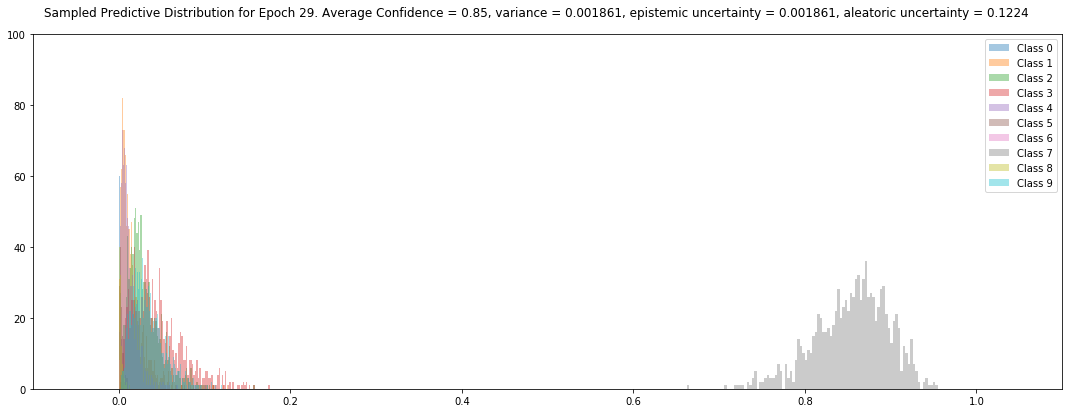

In [0]:
for i in [0, 1, 2, 4, 8, 12, 18, 24, 29]: #range(0, len(classes)):
  outputs = sample_predictive_epoch_normalized_softplus(images[0], i)
  xlim1, xlim2 = ((0.1 - 0.01, 0.11 ), (0.12, 1))
  '''if i == 0:
    xlim1, xlim2 = ((0.1 - 0.01, 0.11 ), (0.12, 1))  #change as necessary to zoom in on the distribution
    broken_ax_plot(outputs, i, xlim1, xlim2)
  elif i == 1:
    xlim1, xlim2 = ((0.1 - 1e-3, 0.1+1e-3 ), (0.1 + 2e-3, 1))
    broken_ax_plot(outputs, i, xlim1, xlim2)
  else:'''
    #xlim1, xlim2 = ((0.1 - 5e-1, 0.1+5e-1 ), (0.1 + 5e-1, 1))
  single_ax_plot(outputs, i)
  
  